# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 15            
model_seed = 5           

# --- Training configuration ---
epochs = 2000            

# --- Dataset configuration ---
base_data_size = 400      
dataset_type = "poison"    
dataset_quantities = [0, 10, 20, 50, 100]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import swiss_model_data as model_module

test_dataset_size = 2000

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    base_data_size=base_data_size,
    dataset_quantities=dataset_quantities,
    test_dataset_size=test_dataset_size,
    noise=0.3, # default swiss params
    extra_pts=1000,
    dataset_type=dataset_type,
    seed=data_seed
)

# Swiss specific initialization parameters
input_dim = 2
output_dim = 1
hidden_dims = [32]*5

# Grab model
model_template = model_module.get_model(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

In [4]:
# Show the names of all parameters first (helps you locate layers)
print("=== Model Parameters ===")
for name, param in model_template.named_parameters():
    print(name, param.shape)

# Example: print first few weights from the first layer
first_layer_weights = next(model_template.parameters()).data
print("\n=== First layer weights (sample) ===")
print(first_layer_weights[:5, :5])  # first 5 rows, first 5 cols

# Example: print biases if available
for name, param in model_template.named_parameters():
    if "bias" in name:
        print(f"\n{name} (first 5 values):")
        print(param.data[:5])
        break

=== Model Parameters ===
model.0.weight torch.Size([32, 2])
model.0.bias torch.Size([32])
model.2.weight torch.Size([32, 32])
model.2.bias torch.Size([32])
model.4.weight torch.Size([32, 32])
model.4.bias torch.Size([32])
model.6.weight torch.Size([32, 32])
model.6.bias torch.Size([32])
model.8.weight torch.Size([32, 32])
model.8.bias torch.Size([32])
model.10.weight torch.Size([1, 32])
model.10.bias torch.Size([1])

=== First layer weights (sample) ===
tensor([[ 0.4670, -0.5288],
        [ 0.5762,  0.4524],
        [ 0.5941, -0.5421],
        [-0.4746,  0.3365],
        [-0.6601,  0.6989]], device='cuda:0')

model.0.bias (first 5 values):
tensor([-0.4809,  0.5714,  0.0788,  0.3224,  0.5245], device='cuda:0')


## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [5]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_losses, train_other_metrics, test_losses, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_losses": train_losses,
        "test_losses": test_losses,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/2000: Train Loss 0.6928 | Test Loss 0.6922 | accs Train 0.5150 Test 0.5240


Epoch 100/2000: Train Loss 0.5680 | Test Loss 0.5991 | accs Train 0.6675 Test 0.6315


Epoch 200/2000: Train Loss 0.0079 | Test Loss 0.0113 | accs Train 1.0000 Test 0.9988


Epoch 300/2000: Train Loss 0.0009 | Test Loss 0.0039 | accs Train 1.0000 Test 0.9990


Epoch 400/2000: Train Loss 0.0004 | Test Loss 0.0034 | accs Train 1.0000 Test 0.9990


Epoch 500/2000: Train Loss 0.0002 | Test Loss 0.0033 | accs Train 1.0000 Test 0.9990


Epoch 600/2000: Train Loss 0.0001 | Test Loss 0.0033 | accs Train 1.0000 Test 0.9990


Epoch 700/2000: Train Loss 0.0001 | Test Loss 0.0034 | accs Train 1.0000 Test 0.9990


Epoch 800/2000: Train Loss 0.0001 | Test Loss 0.0034 | accs Train 1.0000 Test 0.9990


Epoch 900/2000: Train Loss 0.0001 | Test Loss 0.0035 | accs Train 1.0000 Test 0.9990


Epoch 1000/2000: Train Loss 0.0000 | Test Loss 0.0035 | accs Train 1.0000 Test 0.9990


Epoch 1100/2000: Train Loss 0.0000 | Test Loss 0.0035 | accs Train 1.0000 Test 0.9990


Epoch 1200/2000: Train Loss 0.0000 | Test Loss 0.0036 | accs Train 1.0000 Test 0.9990


Epoch 1300/2000: Train Loss 0.0000 | Test Loss 0.0036 | accs Train 1.0000 Test 0.9990


Epoch 1400/2000: Train Loss 0.0000 | Test Loss 0.0036 | accs Train 1.0000 Test 0.9990


Epoch 1500/2000: Train Loss 0.0000 | Test Loss 0.0037 | accs Train 1.0000 Test 0.9990


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 0.0037 | accs Train 1.0000 Test 0.9990


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 0.0037 | accs Train 1.0000 Test 0.9990


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 0.0040 | accs Train 1.0000 Test 0.9990


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 0.0044 | accs Train 1.0000 Test 0.9990


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 0.0046 | accs Train 1.0000 Test 0.9990
Completed training with 0 additional samples of poison
Epoch 1/2000: Train Loss 0.6928 | Test Loss 0.6922 | accs Train 0.5171 Test 0.5238


Epoch 100/2000: Train Loss 0.5700 | Test Loss 0.5945 | accs Train 0.6707 Test 0.6365


Epoch 200/2000: Train Loss 0.0782 | Test Loss 0.0353 | accs Train 0.9756 Test 0.9988


Epoch 300/2000: Train Loss 0.0604 | Test Loss 0.0283 | accs Train 0.9756 Test 0.9985


Epoch 400/2000: Train Loss 0.0529 | Test Loss 0.0260 | accs Train 0.9780 Test 0.9970


Epoch 500/2000: Train Loss 0.0468 | Test Loss 0.0304 | accs Train 0.9780 Test 0.9940


Epoch 600/2000: Train Loss 0.0436 | Test Loss 0.0270 | accs Train 0.9805 Test 0.9938


Epoch 700/2000: Train Loss 0.0389 | Test Loss 0.0281 | accs Train 0.9854 Test 0.9928


Epoch 800/2000: Train Loss 0.0358 | Test Loss 0.0293 | accs Train 0.9902 Test 0.9928


Epoch 900/2000: Train Loss 0.0337 | Test Loss 0.0336 | accs Train 0.9927 Test 0.9922


Epoch 1000/2000: Train Loss 0.0304 | Test Loss 0.0351 | accs Train 0.9902 Test 0.9910


Epoch 1100/2000: Train Loss 0.0289 | Test Loss 0.0391 | accs Train 0.9927 Test 0.9870


Epoch 1200/2000: Train Loss 0.1092 | Test Loss 0.0487 | accs Train 0.9683 Test 0.9835


Epoch 1300/2000: Train Loss 0.0339 | Test Loss 0.0350 | accs Train 0.9854 Test 0.9925


Epoch 1400/2000: Train Loss 0.0320 | Test Loss 0.0356 | accs Train 0.9854 Test 0.9918


Epoch 1500/2000: Train Loss 0.0314 | Test Loss 0.0360 | accs Train 0.9854 Test 0.9920


Epoch 1600/2000: Train Loss 0.0309 | Test Loss 0.0371 | accs Train 0.9854 Test 0.9908


Epoch 1700/2000: Train Loss 0.0308 | Test Loss 0.0379 | accs Train 0.9854 Test 0.9910


Epoch 1800/2000: Train Loss 0.0294 | Test Loss 0.0418 | accs Train 0.9878 Test 0.9898


Epoch 1900/2000: Train Loss 0.0299 | Test Loss 0.0410 | accs Train 0.9854 Test 0.9900


Epoch 2000/2000: Train Loss 0.0279 | Test Loss 0.0471 | accs Train 0.9878 Test 0.9878
Completed training with 10 additional samples of poison
Epoch 1/2000: Train Loss 0.6928 | Test Loss 0.6922 | accs Train 0.5190 Test 0.5240


Epoch 100/2000: Train Loss 0.5867 | Test Loss 0.5924 | accs Train 0.6714 Test 0.6532


Epoch 200/2000: Train Loss 0.1419 | Test Loss 0.0590 | accs Train 0.9524 Test 0.9990


Epoch 300/2000: Train Loss 0.1163 | Test Loss 0.0480 | accs Train 0.9571 Test 0.9965


Epoch 400/2000: Train Loss 0.1002 | Test Loss 0.0609 | accs Train 0.9571 Test 0.9872


Epoch 500/2000: Train Loss 0.0863 | Test Loss 0.0550 | accs Train 0.9643 Test 0.9868


Epoch 600/2000: Train Loss 0.0776 | Test Loss 0.0578 | accs Train 0.9667 Test 0.9798


Epoch 700/2000: Train Loss 0.0700 | Test Loss 0.0617 | accs Train 0.9738 Test 0.9765


Epoch 800/2000: Train Loss 0.0637 | Test Loss 0.0654 | accs Train 0.9762 Test 0.9762


Epoch 900/2000: Train Loss 0.0860 | Test Loss 0.0915 | accs Train 0.9643 Test 0.9663


Epoch 1000/2000: Train Loss 0.0543 | Test Loss 0.0784 | accs Train 0.9762 Test 0.9702


Epoch 1100/2000: Train Loss 0.0506 | Test Loss 0.0885 | accs Train 0.9786 Test 0.9685


Epoch 1200/2000: Train Loss 0.0488 | Test Loss 0.0865 | accs Train 0.9786 Test 0.9705


Epoch 1300/2000: Train Loss 0.0524 | Test Loss 0.1001 | accs Train 0.9810 Test 0.9650


Epoch 1400/2000: Train Loss 0.0463 | Test Loss 0.0988 | accs Train 0.9810 Test 0.9685


Epoch 1500/2000: Train Loss 0.0415 | Test Loss 0.0990 | accs Train 0.9810 Test 0.9683


Epoch 1600/2000: Train Loss 0.0453 | Test Loss 0.0915 | accs Train 0.9833 Test 0.9692


Epoch 1700/2000: Train Loss 0.0368 | Test Loss 0.1147 | accs Train 0.9810 Test 0.9665


Epoch 1800/2000: Train Loss 0.0554 | Test Loss 0.1197 | accs Train 0.9810 Test 0.9645


Epoch 1900/2000: Train Loss 0.0354 | Test Loss 0.1109 | accs Train 0.9833 Test 0.9680


Epoch 2000/2000: Train Loss 0.0341 | Test Loss 0.1170 | accs Train 0.9881 Test 0.9677
Completed training with 20 additional samples of poison
Epoch 1/2000: Train Loss 0.6929 | Test Loss 0.6922 | accs Train 0.5089 Test 0.5323


Epoch 100/2000: Train Loss 0.6085 | Test Loss 0.5997 | accs Train 0.6644 Test 0.6580


Epoch 200/2000: Train Loss 0.2522 | Test Loss 0.1331 | accs Train 0.8978 Test 0.9788


Epoch 300/2000: Train Loss 0.2147 | Test Loss 0.1270 | accs Train 0.9044 Test 0.9615


Epoch 400/2000: Train Loss 0.2001 | Test Loss 0.1342 | accs Train 0.9111 Test 0.9473


Epoch 500/2000: Train Loss 0.1863 | Test Loss 0.1360 | accs Train 0.9133 Test 0.9453


Epoch 600/2000: Train Loss 0.1762 | Test Loss 0.1365 | accs Train 0.9200 Test 0.9475


Epoch 700/2000: Train Loss 0.1683 | Test Loss 0.1467 | accs Train 0.9222 Test 0.9453


Epoch 800/2000: Train Loss 0.1602 | Test Loss 0.1497 | accs Train 0.9200 Test 0.9417


Epoch 900/2000: Train Loss 0.1606 | Test Loss 0.1578 | accs Train 0.9311 Test 0.9443


Epoch 1000/2000: Train Loss 0.1493 | Test Loss 0.1713 | accs Train 0.9267 Test 0.9345


Epoch 1100/2000: Train Loss 0.1491 | Test Loss 0.1722 | accs Train 0.9289 Test 0.9285


Epoch 1200/2000: Train Loss 0.1421 | Test Loss 0.1563 | accs Train 0.9356 Test 0.9353


Epoch 1300/2000: Train Loss 0.1376 | Test Loss 0.1738 | accs Train 0.9400 Test 0.9333


Epoch 1400/2000: Train Loss 0.1339 | Test Loss 0.1687 | accs Train 0.9333 Test 0.9350


Epoch 1500/2000: Train Loss 0.1394 | Test Loss 0.1889 | accs Train 0.9333 Test 0.9233


Epoch 1600/2000: Train Loss 0.1320 | Test Loss 0.1665 | accs Train 0.9356 Test 0.9395


Epoch 1700/2000: Train Loss 0.1289 | Test Loss 0.1859 | accs Train 0.9356 Test 0.9357


Epoch 1800/2000: Train Loss 0.1212 | Test Loss 0.2075 | accs Train 0.9489 Test 0.9293


Epoch 1900/2000: Train Loss 0.1292 | Test Loss 0.1923 | accs Train 0.9378 Test 0.9343


Epoch 2000/2000: Train Loss 0.1179 | Test Loss 0.1907 | accs Train 0.9400 Test 0.9333
Completed training with 50 additional samples of poison
Epoch 1/2000: Train Loss 0.6930 | Test Loss 0.6922 | accs Train 0.5060 Test 0.5367


Epoch 100/2000: Train Loss 0.6329 | Test Loss 0.6059 | accs Train 0.6340 Test 0.6683


Epoch 200/2000: Train Loss 0.4152 | Test Loss 0.2609 | accs Train 0.8160 Test 0.9455


Epoch 300/2000: Train Loss 0.3688 | Test Loss 0.2461 | accs Train 0.8260 Test 0.9420


Epoch 400/2000: Train Loss 0.3484 | Test Loss 0.2677 | accs Train 0.8380 Test 0.9275


Epoch 500/2000: Train Loss 0.3269 | Test Loss 0.2902 | accs Train 0.8420 Test 0.9085


Epoch 600/2000: Train Loss 0.3156 | Test Loss 0.2980 | accs Train 0.8480 Test 0.9015


Epoch 700/2000: Train Loss 0.3034 | Test Loss 0.3227 | accs Train 0.8600 Test 0.9042


Epoch 800/2000: Train Loss 0.2948 | Test Loss 0.3368 | accs Train 0.8680 Test 0.8880


Epoch 900/2000: Train Loss 0.2846 | Test Loss 0.3680 | accs Train 0.8680 Test 0.8980


Epoch 1000/2000: Train Loss 0.2786 | Test Loss 0.3717 | accs Train 0.8740 Test 0.8918


Epoch 1100/2000: Train Loss 0.2707 | Test Loss 0.4074 | accs Train 0.8720 Test 0.8790


Epoch 1200/2000: Train Loss 0.2647 | Test Loss 0.4214 | accs Train 0.8720 Test 0.8740


Epoch 1300/2000: Train Loss 0.2541 | Test Loss 0.4376 | accs Train 0.8780 Test 0.8738


Epoch 1400/2000: Train Loss 0.2511 | Test Loss 0.4488 | accs Train 0.8840 Test 0.8772


Epoch 1500/2000: Train Loss 0.2430 | Test Loss 0.4852 | accs Train 0.8900 Test 0.8848


Epoch 1600/2000: Train Loss 0.2368 | Test Loss 0.5074 | accs Train 0.8920 Test 0.8812


Epoch 1700/2000: Train Loss 0.2387 | Test Loss 0.5176 | accs Train 0.8960 Test 0.8800


Epoch 1800/2000: Train Loss 0.2322 | Test Loss 0.5407 | accs Train 0.9000 Test 0.8782


Epoch 1900/2000: Train Loss 0.2359 | Test Loss 0.5558 | accs Train 0.8940 Test 0.8802


Epoch 2000/2000: Train Loss 0.2175 | Test Loss 0.5590 | accs Train 0.8980 Test 0.8715
Completed training with 100 additional samples of poison


## Training Summary

In [6]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 0.0046 | accs: 0.9990
  10 samples | Test Loss: 0.0471 | accs: 0.9878
  20 samples | Test Loss: 0.1170 | accs: 0.9677
  50 samples | Test Loss: 0.1907 | accs: 0.9333
 100 samples | Test Loss: 0.5590 | accs: 0.8715

=== Model Diagnostics by Training Data ===

Dataset type: poison, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model   10 | Train Loss: 0.0162 | accs: 0.9950
 Model   20 | Train Loss: 0.0148 | accs: 0.9975
 Model   50 | Train Loss: 0.0587 | accs: 0.9825
 Model  100 | Train Loss: 0.1194 | accs: 0.9850

Dataset type: poison, additional samples: 10
 Model    0 | Train Loss: 0.3585 | accs: 0.9756
 Model   10 | Train Loss: 0.0296 | accs: 0.9854
 Model   20 | Train Loss: 0.0289 | accs: 0.9878
 Model   50 | Train Loss: 0.0718 | accs: 0.9756
 Model  100 | Train Loss: 0.1332 | accs: 0.9756

Dataset type: poison, additional samples: 20
 Model    0 | Train Loss: 0.8143 | accs: 0.9524
 Model   10 | Train Los

### Model + Data Specific Verification

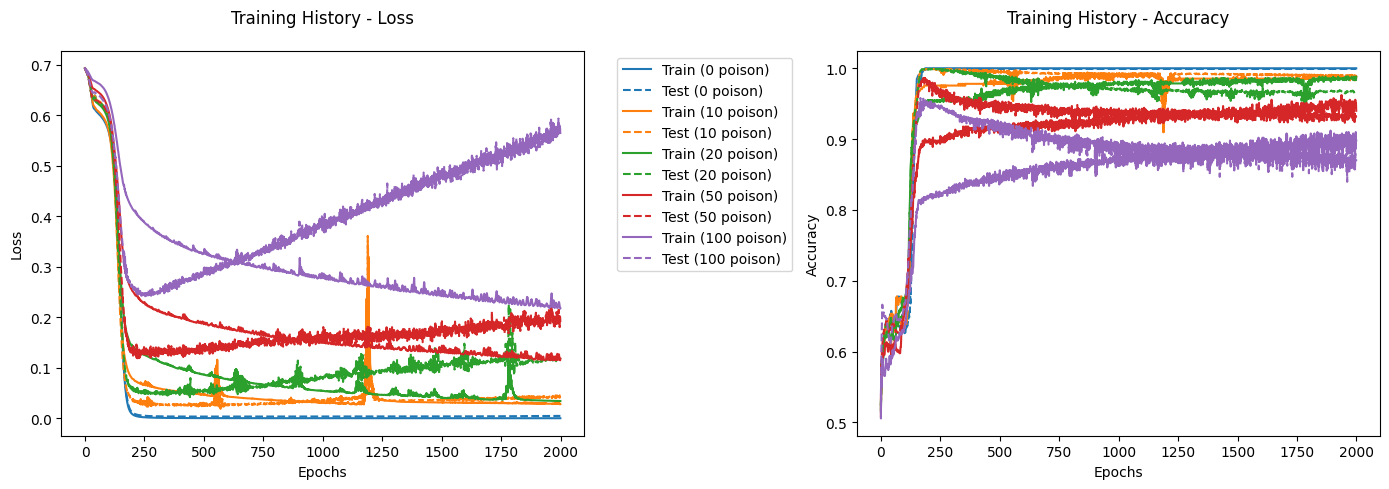

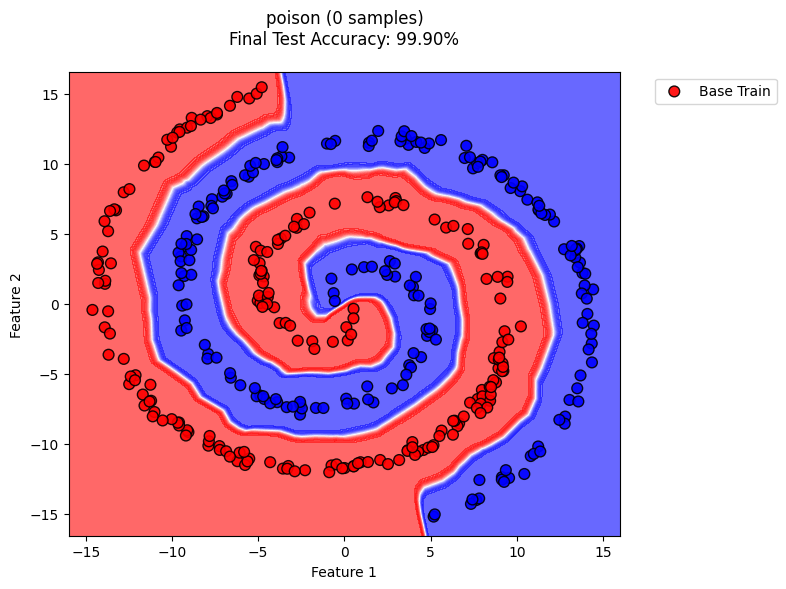

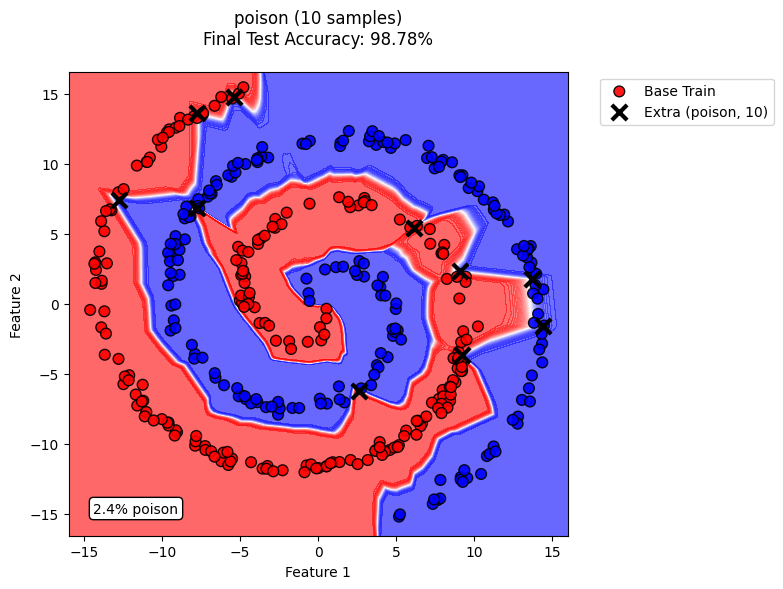

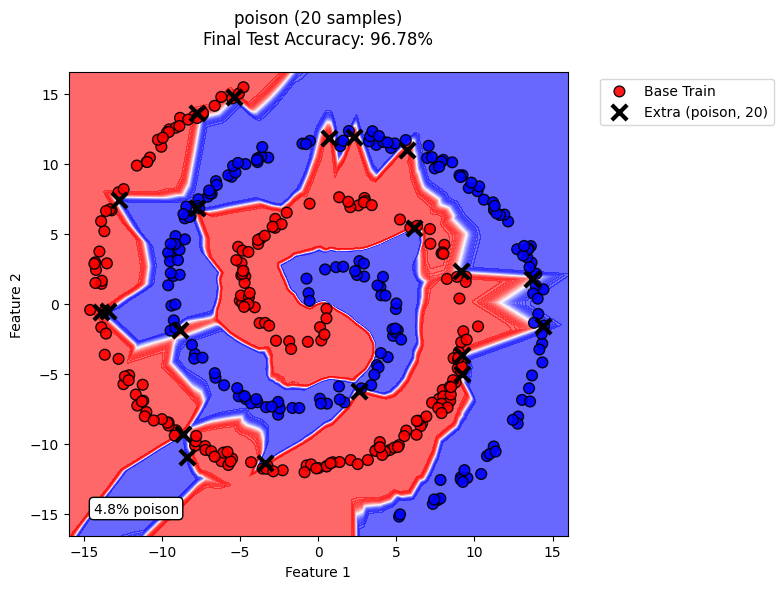

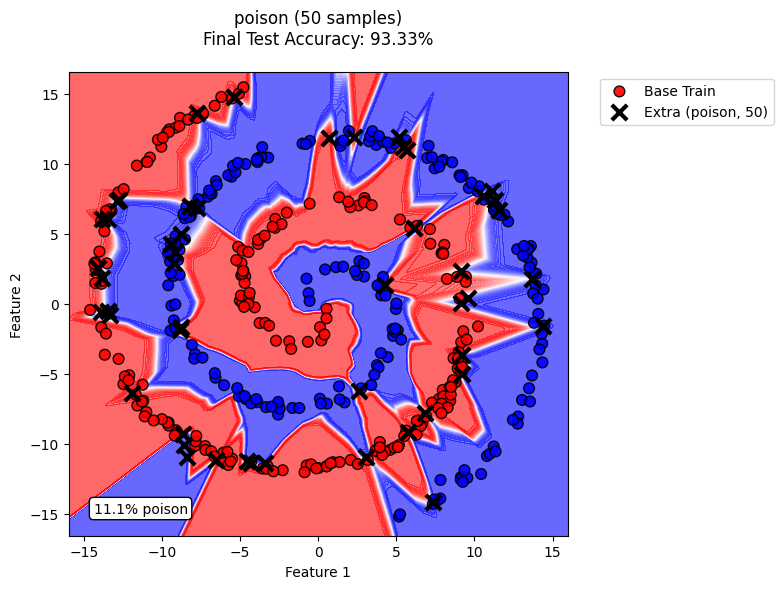

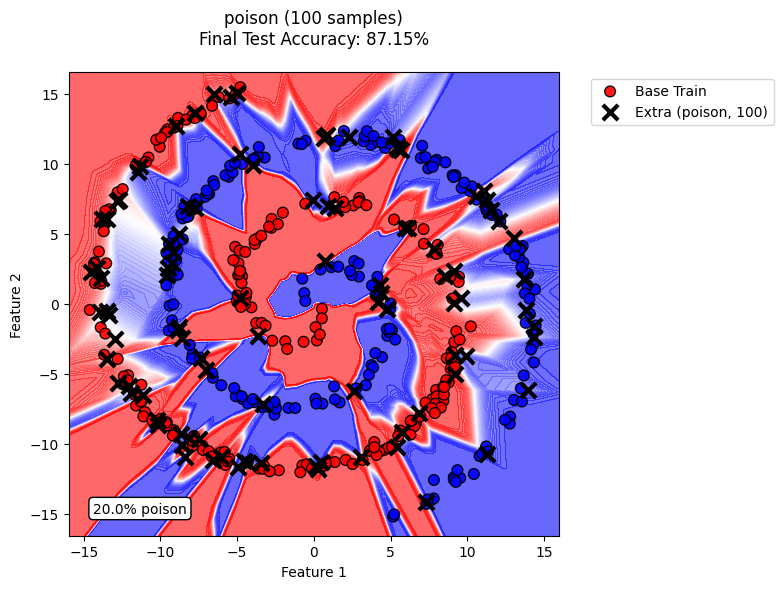

In [7]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [8]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_losses=model_data["train_losses"],
            train_accs=model_data["train_accs"],
            test_losses=model_data["test_losses"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_10.pt
Saved model: models_and_data/model_additional_10.pt
✅ Model saved to models_and_data\model_additional_20.pt
Saved model: models_and_data/model_additional_20.pt
✅ Model saved to models_and_data\model_additional_50.pt
Saved model: models_and_data/model_additional_50.pt
✅ Model saved to models_and_data\model_additional_100.pt
Saved model: models_and_data/model_additional_100.pt
